In [126]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

In [127]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

In [128]:
currency = 'BTC'
against_currency = 'USD'

In [129]:
start = dt.datetime(2016,1,1)
end = dt.datetime.now()

In [130]:
data = web.DataReader(f'{currency}-{against_currency}', 'yahoo', start, end)

In [131]:
data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-12-31,432.920990,418.734985,425.875000,430.566986,45996600,430.566986
2016-01-01,436.246002,427.515015,430.721008,434.334015,36278900,434.334015
2016-01-02,436.062012,431.869995,434.622009,433.437988,30096600,433.437988
2016-01-03,433.743011,424.705994,433.578003,430.010986,39633800,430.010986
2016-01-04,434.516998,429.084015,430.061005,433.091003,38477500,433.091003
...,...,...,...,...,...,...
2022-01-30,38266.339844,37437.710938,38151.917969,37917.601562,14643548444,37917.601562
2022-01-31,38647.261719,36733.574219,37920.281250,38483.125000,20734730465,38483.125000
2022-02-01,39115.132812,38113.664062,38481.765625,38743.273438,20288500328,38743.273438


In [132]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [133]:
df1[:5]

array([[0.00098562],
       [0.00104167],
       [0.00102834],
       [0.00097734],
       [0.00102318]])

In [134]:
prediction_days = 60

#for future predictions we use this
future_day = 1

X_train,y_train = [],[]

for i in range(prediction_days, len(df1)- future_day):
    X_train.append(df1[i-prediction_days:i, 0])
    y_train.append(df1[future_day+i,0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

In [135]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [136]:
#creating the neural network
import tensorflow as tf

model = Sequential()

model.add(LSTM(units=50, return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam',loss='mean_squared_error')

model.fit(X_train,y_train, epochs=40, batch_size=32)

Epoch 1/40
68/68 [==============================] - 6s 36ms/step - loss: 0.0095
Epoch 2/40
68/68 [==============================] - 2s 37ms/step - loss: 0.0031
Epoch 3/40
68/68 [==============================] - 2s 36ms/step - loss: 0.0024
Epoch 4/40
68/68 [==============================] - 2s 37ms/step - loss: 0.0021
Epoch 5/40
68/68 [==============================] - 3s 38ms/step - loss: 0.0025
Epoch 6/40
68/68 [==============================] - 3s 37ms/step - loss: 0.0017
Epoch 7/40
68/68 [==============================] - 3s 37ms/step - loss: 0.0020
Epoch 8/40
68/68 [==============================] - 2s 37ms/step - loss: 0.0020: 0s - lo
Epoch 9/40
68/68 [==============================] - 2s 37ms/step - loss: 0.0019
Epoch 10/40
68/68 [==============================] - 3s 37ms/step - loss: 0.0018
Epoch 11/40
68/68 [==============================] - 3s 37ms/step - loss: 0.0019
Epoch 12/40
68/68 [==============================] - 2s 37ms/step - loss: 0.0016
Epoch 13/40
68/68 [=========

In [137]:
test_start = dt.datetime(2021,1,1)
test_end = dt.datetime.now()


test_data = web.DataReader(f'{currency}-{against_currency}', 'yahoo', test_start, test_end)

actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']),axis=0)
total_dataset

Date
2015-12-31      430.566986
2016-01-01      434.334015
2016-01-02      433.437988
2016-01-03      430.010986
2016-01-04      433.091003
                  ...     
2022-01-30    37917.601562
2022-01-31    38483.125000
2022-02-01    38743.273438
2022-02-02    36952.984375
2022-02-03    36809.769531
Name: Close, Length: 2627, dtype: float64

In [138]:
model_inputs = total_dataset[len(total_dataset)- len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.fit_transform(model_inputs)

X_test = []

for i in range(prediction_days, len(model_inputs)):
    X_test.append(model_inputs[i - prediction_days:i, 0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [139]:
predicted_prices = model.predict(X_test)
# predicted_prices

In [140]:
predicted = scaler.inverse_transform(predicted_prices)
predicted

array([[38302.55 ],
       [37064.855],
       [35163.58 ],
       [33341.63 ],
       [32017.836],
       [31225.762],
       [31097.861],
       [31815.18 ],
       [33439.16 ],
       [35733.69 ],
       [38054.35 ],
       [39640.8  ],
       [40000.605],
       [39242.14 ],
       [38252.055],
       [37648.605],
       [37267.78 ],
       [36954.81 ],
       [36631.266],
       [36410.348],
       [36252.055],
       [36084.15 ],
       [35396.367],
       [34524.574],
       [33616.25 ],
       [32837.71 ],
       [32284.15 ],
       [31993.021],
       [31714.023],
       [31695.586],
       [32042.006],
       [32641.305],
       [33192.28 ],
       [33606.965],
       [34079.47 ],
       [34831.188],
       [35696.16 ],
       [36634.223],
       [37639.926],
       [38518.664],
       [40144.355],
       [42368.355],
       [44359.992],
       [46161.37 ],
       [47489.266],
       [48179.164],
       [48587.65 ],
       [48693.047],
       [48792.89 ],
       [49419.49 ],


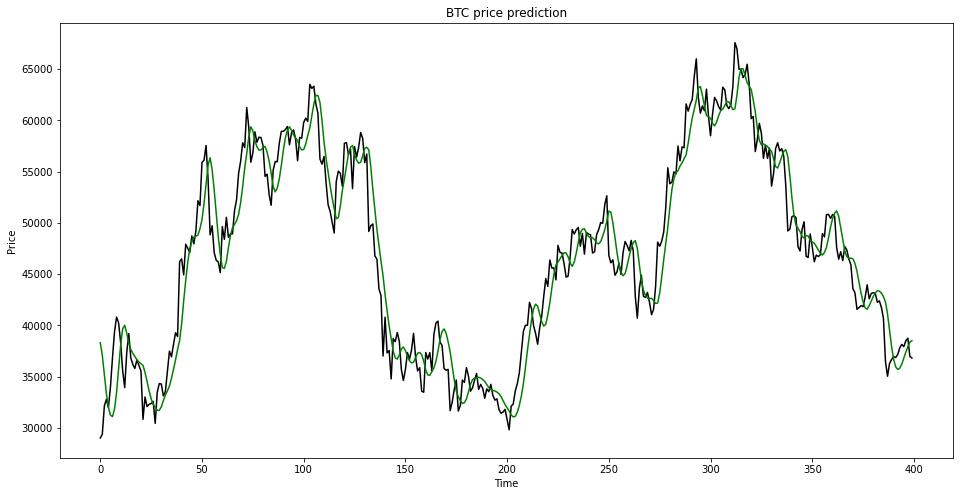

In [141]:
plt.figure(figsize=(16,8))
plt.plot(actual_prices, color='black', label='Actual prices')
plt.plot(predicted, color='green', label='Predicted prices')

plt.title(f'{currency} price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
# plt.legend(loc='upper left')
plt.show()

In [142]:
#Predict next day
real_data = [model_inputs[len(model_inputs) - prediction_days:len(model_inputs)+1,0]]
    
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

In [143]:
prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(prediction)

[[38302.45]]
